In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os 
os.chdir('/content/drive/My Drive/Mestrado/2021.1/Redes Neurais Artificiais/RNA/')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import math

from models import utils, metrics, plots

from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import random
import seaborn as sns
from copy import deepcopy

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
conjunto_1 = utils.make_coords(coord_limit_x = (2, 4), 
                               coord_limit_y = (8, 10),
                               target= 1,
                               len_set = 50) # Top left


conjunto_2 = utils.make_coords(coord_limit_x = (2,4), 
                               coord_limit_y = (2,4),
                               target= 0, 
                               len_set = 50) # Bottom

conjunto_3 = utils.make_coords(coord_limit_x = (8, 10), 
                               coord_limit_y = (8, 10),
                               target= 0,
                               len_set = 50) # Bottom right

conjunto_4 = utils.make_coords(coord_limit_x = (8, 10), 
                               coord_limit_y = (2, 4),
                               target= 1,
                               len_set = 50) # Bottom right

df_artificial_1 = pd.DataFrame(data= conjunto_2 + conjunto_4 + conjunto_1 + conjunto_3, columns=['x1', 'x2', 'target'])

for col in df_artificial_1.columns:
    if col != 'target':
        df_artificial_1 = utils.normalize_col(df_artificial_1, col)

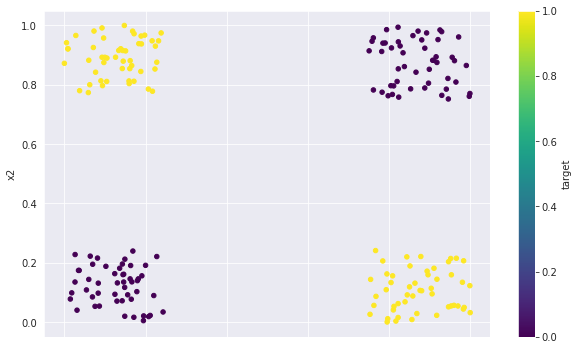

In [ ]:
df_artificial_1.plot.scatter( x='x1', y='x2', c='target', colormap='viridis', figsize=(10,6))

In [ ]:
class MLPClassifier():

      def __init__(self, n_epochs, qt_neurons_hide, qt_neuron_output, learning_rate=0.1, func_ativacao=None):
          self.n_epochs = n_epochs
          self.learning_rate = learning_rate
          self.qt_neurons_hide = qt_neurons_hide
          self.qt_neuron_output = qt_neuron_output
          if func_ativacao == 'logistic':
              self.func_ativacao = self.logistic
              self.func_deriv_ativacao = self.logistic_deriv
          elif func_ativacao == 'tangente':
              self.func_ativacao = self.tanh
              self.func_deriv_ativacao = tanh_deriv

      def logistic(self, u):
        return 1.0 / (1.0 + np.exp(-u))

      def logistic_deriv(self, Y):
          return Y * (1.0 - Y)

      def tanh(self, u):
          return (1 - np.exp(-u)) / (1 + np.exp(-u))

      def tanh_deriv(self, Y):
          return 1.0 - (Y**2)
      
      def degrau(self, u, threshold=0, verify=True):
          if verify:
              if self.func_ativacao == self.logistic:
                  threshold = 0.5
          if u >= threshold: return 1
          else: return 0

      def __calc_u(self, vect_input, vect_weigths):
          return np.dot(vect_input, vect_weigths)

      def train(self, X_train, y_train):

          self.qt_neuron_input = len(X_train.columns)

          # Criando pesos aleatórios
          self.weights_hide = np.random.uniform(size=(self.qt_neuron_input, self.qt_neurons_hide))
          self.weights_hidde_bias = np.random.uniform(size=(1, self.qt_neurons_hide))
          self.weights_output = np.random.uniform(size=(self.qt_neurons_hide, self.qt_neuron_output))
          self.weights_output_bias = np.random.uniform(size=(1, self.qt_neuron_output))

          df_train = X_train.copy()
          df_train['target'] = y_train
          X = df_train.drop(['target'], axis=1).values
          desejavel = df_train[['target']].values

          for _ in range(self.n_epochs):
              
              #Foward
              vec_u_hide = self.__calc_u(X, self.weights_hide) 
              vec_u_hide += self.weights_hidde_bias
              output_layer_hide = self.func_ativacao(vec_u_hide)

              vec_u_output = self.__calc_u(output_layer_hide, self.weights_output) 
              vec_u_output += self.weights_output_bias
              predict = self.func_ativacao(vec_u_output)

              #Backword
              error = desejavel - predict
              list_error.append(sum(error))
              deriv_predict = error * self.func_deriv_ativacao(predict) # ej * y'
              
              error_hide = deriv_predict.dot(self.weights_output.T) #(mji * ej * y')
              deriv_hide = error_hide * self.func_deriv_ativacao(output_layer_hide) # mji * ej * y' * hi'

              #Atualizando todos os pesos
              self.weights_output += output_layer_hide.T.dot(deriv_predict) * self.learning_rate
              self.weights_output_bias += np.sum(deriv_predict,axis=0, keepdims=True) * self.learning_rate
              self.weights_hide += X.T.dot(deriv_hide) * self.learning_rate
              self.weights_hidde_bias += np.sum(deriv_hide,axis=0, keepdims=True) * self.learning_rate

      def predict(self, X_test):

          list_predict = []
          
          X = X_test.values
          
          # Foward
          vec_u_hide = self.__calc_u(X, self.weights_hide)
          vec_u_hide += self.weights_hidde_bias
          output_layer_hide = self.func_ativacao(vec_u_hide)

          vec_u_output = self.__calc_u(output_layer_hide, self.weights_output) 
          vec_u_output += self.weights_output_bias
          predict = self.func_ativacao(vec_u_output)

          return list(map(self.degrau, predict))

In [ ]:
mlp = MLPClassifier(
    n_epochs = 10000, 
    qt_neurons_hide = 2, 
    qt_neuron_output = 1, 
    learning_rate = 0.1, 
    func_ativacao ='logistic'
)

In [ ]:
X_train, y_train, X_test, y_test = utils.split_train_test(df_artificial_1, 'target', train_size=0.8, stratify=True)

In [ ]:
mlp.train(X_train, y_train)

In [ ]:
df_test = X_test.copy()
df_test['target'] = y_test
df_test['predict'] = mlp.predict(X_test)

In [ ]:
metrics.taxa_acerto(df_test['target'], df_test['predict'])

1.0

In [ ]:
import math

def converterGrausParaRad(numero):
    rad = (numero/180)*math.pi
    return rad

def seno(numero):
    resultado = 0
    resultado = math.sqrt(1 - (coseno(numero))**2)
    return resultado

def coseno(rad):
    numero = converterGrausParaRad(rad)
    cont = 0
    resultado = 0
    while(cont < 50):
        resultado += (((-1)**cont)*(numero**(2 * cont)))/(math.factorial(2 * cont))
        cont += 1

    return round(resultado, 6)

In [ ]:
x = list(range(-10, 10))
y = [3 * seno(x) + 1 for i in x]

df_artificial_1 =  pd.DataFrame(data=zip(x,y), columns =['x', 'target'])

df_artificial_1 = utils.normalize_col(df_artificial_1, 'x')

df_artificial_1 = utils.normalize_col(df_artificial_1, 'target')

TypeError: ignored

In [ ]:
plt.scatter(df_artificial_1['x'], df_artificial_1['target'])
plt.title("Artificial I - Com ruído")
plt.xlabel("x")
plt.ylabel("y")
plt.savefig('artificial_1_com_ruido.png')

In [ ]:
class MLPRegressor():

      def __init__(self, n_epochs, qt_neurons_hide, qt_neuron_output, learning_rate=0.1, func_ativacao=None):
          self.n_epochs = n_epochs
          self.learning_rate = learning_rate
          self.qt_neurons_hide = qt_neurons_hide
          self.qt_neuron_output = qt_neuron_output
          if func_ativacao == 'logistic':
              self.func_ativacao = self.logistic
              self.func_deriv_ativacao = self.logistic_deriv
          elif func_ativacao == 'tangente':
              self.func_ativacao = self.tanh
              self.func_deriv_ativacao = tanh_deriv

      def logistic(self, u):
        return 1.0 / (1.0 + np.exp(-u))

      def logistic_deriv(self, Y):
          return Y * (1.0 - Y)

      def tanh(self, u):
          return (1 - np.exp(-u)) / (1 + np.exp(-u))

      def tanh_deriv(self, Y):
          return 1.0 - (Y**2)
      
      def degrau(self, u, threshold=0, verify=True):
          if verify:
              if self.func_ativacao == self.logistic:
                  threshold = 0.5
          if u >= threshold: return 1
          else: return 0

      def __calc_u(self, vect_input, vect_weigths):
          return np.dot(vect_input, vect_weigths)

      def train(self, X_train, y_train):

          self.qt_neuron_input = len(X_train.columns)

          # Criando pesos aleatórios
          self.weights_hide = np.random.uniform(size=(self.qt_neuron_input, self.qt_neurons_hide))
          self.weights_hidde_bias = np.random.uniform(size=(1, self.qt_neurons_hide))
          self.weights_output = np.random.uniform(size=(self.qt_neurons_hide, self.qt_neuron_output))
          self.weights_output_bias = np.random.uniform(size=(1, self.qt_neuron_output))

          df_train = X_train.copy()
          df_train['target'] = y_train
          X = df_train.drop(['target'], axis=1).values
          desejavel = df_train[['target']].values
          list_error = []
          mse = 0
          for _ in range(self.n_epochs):
              
              #Foward
              vec_u_hide = self.__calc_u(X, self.weights_hide) 
              vec_u_hide += self.weights_hidde_bias
              output_layer_hide = self.func_ativacao(vec_u_hide)

              vec_u_output = self.__calc_u(output_layer_hide, self.weights_output) 
              vec_u_output += self.weights_output_bias
              predict = vec_u_output#self.func_ativacao(vec_u_output)

              #Backword
              error = (desejavel - predict) ** 2 
              print(error)
              list_error.append(sum(error))
              deriv_predict = error * self.func_deriv_ativacao(predict) # ej * y'
              
              error_hide = deriv_predict.dot(self.weights_output.T) #(mji * ej * y')
              deriv_hide = error_hide * self.func_deriv_ativacao(output_layer_hide) # mji * ej * y' * hi'

              #Atualizando todos os pesos
              self.weights_output += output_layer_hide.T.dot(deriv_predict) * self.learning_rate
              self.weights_output_bias += np.sum(deriv_predict,axis=0, keepdims=True) * self.learning_rate
              self.weights_hide += X.T.dot(deriv_hide) * self.learning_rate
              self.weights_hidde_bias += np.sum(deriv_hide,axis=0, keepdims=True) * self.learning_rate

          mse = sum(list_error) / len(list_error)
          print(mse)

      def predict(self, X_test):

          list_predict = []
          
          X = X_test.values
          
          # Foward
          vec_u_hide = self.__calc_u(X, self.weights_hide)
          vec_u_hide += self.weights_hidde_bias
          output_layer_hide = self.func_ativacao(vec_u_hide)

          vec_u_output = self.__calc_u(output_layer_hide, self.weights_output) 
          vec_u_output += self.weights_output_bias
          predict = vec_u_output

          return list(predict)

In [ ]:
df_abalone = pd.read_csv('datasets/abalone/abalone.csv')
df_abalone['target'] = df_abalone.Rings + 1.5
df_abalone = df_abalone[['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings', 'target']]

In [ ]:
df_abalone.head(1)

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,target
0,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15,16.5


In [ ]:
mlp = MLPRegressor(
    n_epochs = 100, 
    qt_neurons_hide = 2, 
    qt_neuron_output = 1, 
    learning_rate = 0.1, 
    func_ativacao ='logistic'
)

In [ ]:
X_train, y_train, X_test, y_test = utils.split_train_test(df_abalone, 'target', train_size=0.8, stratify=None)

In [ ]:
mlp.train(X_train, y_train)

[[ 40.09128078]
 [235.02032682]
 [ 18.86241045]
 ...
 [ 53.74475906]
 [ 87.05793375]
 [152.03831679]]
[[2.11395089e+08]
 [2.34664571e+08]
 [1.74592655e+08]
 ...
 [2.09609317e+08]
 [2.21436604e+08]
 [2.28402582e+08]]
[[1.11290103e+39]
 [1.11290103e+39]
 [1.11290103e+39]
 ...
 [1.11290103e+39]
 [1.11290103e+39]
 [1.11290103e+39]]
[[1.54199005e+162]
 [1.54199005e+162]
 [1.54199005e+162]
 ...
 [1.54199005e+162]
 [1.54199005e+162]
 [1.54199005e+162]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in multiply


A saída de streaming foi truncada nas últimas 5000 linhas.
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
[[nan]
 [nan]


KeyboardInterrupt: ignored

In [ ]:
df_test = X_test.copy()
df_test['target'] = y_test
df_test['predict'] = mlp.predict(X_test)

In [ ]:
metrics.taxa_acerto(df_test['target'], df_test['predict'])

0.0